# Построение нейронной сети средствами Tensorflow
В этом блокноте мы покажем, как можно создать полносвязную нейронную сеть с нуля средствами Tensorflow

In [ ]:
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Загрузим знакомые нам данные — набор данных MNIST, будем решать задачу классификации

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Посмотрим на объемы загруженных данных

In [ ]:
print('Training data size : ', x_train.shape)
print('Test data size: ', x_test.shape)

Training data size :  (60000, 28, 28)
Test data size:  (10000, 28, 28)


Выведем какое-нибудь изображение, проверим, что на первый взгляд данные подгрузились корректно, метки классов разумны.

Label выводимого изображения: 5


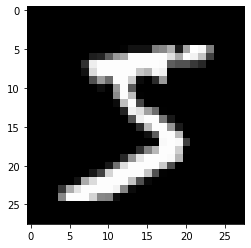

In [ ]:
plt.imshow(x_train[0], cmap='gray')
print('Label выводимого изображения:', y_train[0])
plt.show()

Сформируем данные-строки для подачи на вход нейронной сети, нормируем данные

In [ ]:
X_train = x_train.reshape(-1, 28 * 28)
X_train = X_train.astype('float32') / 255
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Укажем, что лейблы — целые

In [ ]:
y_train = y_train.astype('int64')
y_train

array([5, 0, 4, ..., 5, 6, 8])

То же самое проделаем с тестовыми данными

In [ ]:
X_test = x_test.reshape(-1, 28 * 28)
X_test = X_test.astype('float32') / 255
y_test = y_test.astype('int64')

Будем строить нейронную сеть с тремя скрытыми слоями. Укажем размер батча для шага обучения, количество входных параметров, количество нейронов в скрытых слоях и количество выходных нейронов (их, конечно, $10$).

In [ ]:
batch_size = 100  # размер батча для обучения
num_input = 784  # количество входных нейронов (28 * 28)
num_hidden1 = 128  # количество нейронов первого скрытого слоя
num_hidden2 = 256  # количество нейронов второго скрытого слоя
num_hidden3 = 128  # количество нейронов третьего скрытого слоя
num_output = 10  # количество выходов (такое же, как количество классов)

Теперь создадим архитектуру сети. Обратите внимание, что мы используем следующую модель действия слоя:
$$
Y = XW + b, \quad Z = \varphi(Y),
$$
$\varphi$ -- функция активации, что не противоречит ничему из изложенного в предыдущих лекциях.


In [ ]:
def multi_layer_perceptron_mnist(x):
    # создаем первый скрытый слой со своими весами и сдвигами, используем ReLU в качестве функции активации
    hidden_layer1 = tf.add(tf.matmul(x, weights['w_h1']), biases['b_h1'])
    hidden_layer1 = tf.nn.relu(hidden_layer1)
    # создаем второй скрытый слой со своими весами и сдвигами, используем ReLU в качестве функции активации
    hidden_layer2 = tf.add(tf.matmul(hidden_layer1, weights['w_h2']), biases['b_h2'])
    hidden_layer2 = tf.nn.relu(hidden_layer2)
    # создаем третий скрытый слой со своими весами и сдвигами, используем ReLU в качестве функции активации, при обучении используем dropout
    hidden_drop = tf.nn.dropout(hidden_layer2, 0.1)
    hidden_layer3 = tf.add(tf.matmul(hidden_drop, weights['w_h3']), biases['b_h3'])
    hidden_layer3 = tf.nn.relu(hidden_layer3)
    # создаем последний слой, в качестве функции активации будет использоваться Softmax-подход, его введем в loss-части
    out_layer = tf.add(tf.matmul(hidden_layer3, weights['w_out']), biases['b_out'])
    return out_layer

In [ ]:
# случайным образом инициализируем веса и сдвиги соответствующих размеров,
# инициализация идет согласно стандартному нормальному закону
weights = {
    'w_h1': tf.Variable(tf.random.normal([num_input, num_hidden1])),
    'w_h2': tf.Variable(tf.random.normal([num_hidden1, num_hidden2])),
    'w_h3': tf.Variable(tf.random.normal([num_hidden2, num_hidden3])),
    'w_out': tf.Variable(tf.random.normal([num_hidden3, num_output]))
}
biases = {
    'b_h1': tf.Variable(tf.random.normal([num_hidden1])),
    'b_h2': tf.Variable(tf.random.normal([num_hidden2])),
    'b_h3': tf.Variable(tf.random.normal([num_hidden3])),
    'b_out': tf.Variable(tf.random.normal([num_output]))
}

Теперь зададим проход вперед по подаваемому батчу данных.

In [ ]:
def forward_pass(x):
    return multi_layer_perceptron_mnist(x)

Будем минимизировать Softmax кросс-энтропию. Обратите внимание, мы вызываем только прямой проход.

In [ ]:
def loss():
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=forward_pass(X_batch), labels=y_batch))

Зададим оптимизатор, например, снова Adam.

In [ ]:
optimizer = tf.optimizers.Adam(0.01)

Теперь начинаем обучаться.

In [ ]:
ep_number = 50
batch_size = 1000
display_step = 10

In [ ]:
for ep in range(ep_number):
    for _ in range(0, int(len(X_train) / batch_size - 1)):
        X_batch = X_train[_ * batch_size: (_ + 1) * batch_size]
        y_batch = y_train[_ * batch_size: (_ + 1) * batch_size]
        optimizer.minimize(loss, [weights, biases])
    X_batch = X_train[(_ + 1) * batch_size:]
    y_batch = y_train[(_ + 1) * batch_size:]
    optimizer.minimize(loss, [weights, biases])
    print('Epoch: ' + str(ep + 1) + ' Loss: ' + str(loss()))

Epoch: 1 Loss: tf.Tensor(131.50647, shape=(), dtype=float32)
Epoch: 2 Loss: tf.Tensor(63.20613, shape=(), dtype=float32)
Epoch: 3 Loss: tf.Tensor(38.609184, shape=(), dtype=float32)
Epoch: 4 Loss: tf.Tensor(26.951572, shape=(), dtype=float32)
Epoch: 5 Loss: tf.Tensor(19.399809, shape=(), dtype=float32)
Epoch: 6 Loss: tf.Tensor(15.339075, shape=(), dtype=float32)
Epoch: 7 Loss: tf.Tensor(12.300134, shape=(), dtype=float32)
Epoch: 8 Loss: tf.Tensor(9.967913, shape=(), dtype=float32)
Epoch: 9 Loss: tf.Tensor(7.693338, shape=(), dtype=float32)
Epoch: 10 Loss: tf.Tensor(6.2857404, shape=(), dtype=float32)
Epoch: 11 Loss: tf.Tensor(3.895321, shape=(), dtype=float32)
Epoch: 12 Loss: tf.Tensor(3.1457236, shape=(), dtype=float32)
Epoch: 13 Loss: tf.Tensor(2.803691, shape=(), dtype=float32)
Epoch: 14 Loss: tf.Tensor(2.1655254, shape=(), dtype=float32)
Epoch: 15 Loss: tf.Tensor(1.8859129, shape=(), dtype=float32)
Epoch: 16 Loss: tf.Tensor(2.0784137, shape=(), dtype=float32)
Epoch: 17 Loss: tf.Ten

Похоже, результаты неплохи, обучение происходит весьма быстро. Давайте посмотрим на результаты на тестовой выборке

In [ ]:
results = tf.nn.softmax(forward_pass(X_test))

Напомним, что в качестве результата мы должны получить для каждой тестовой цифры набор из $10$ вероятностей — вероятностей классов, которые модель сопоставляет подаваемому объекту. Например, мы видим, что модель абсолютно уверена, что в качестве первого объекта тестового набора данных выступает цифра $7$. Визуализация показывает, что это и правда так.

In [ ]:
results[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

In [ ]:
image = np.reshape(X_test[0], [-1, 28])

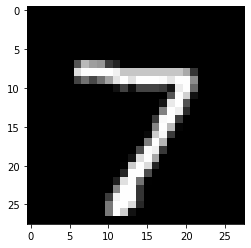

In [ ]:
plt.imshow(image, cmap='gray')
plt.show()

Давайте поймем, как там с Accuracy. Чтобы работать с одинаковым типом данных, переведем истинные отклики из массива типа `numpy` в `Tensor`.

In [ ]:
y_test = tf.constant(y_test)

Посмотрим на совпадение предсказаний и истинных меток классов

In [ ]:
correct_predictions = tf.equal(tf.argmax(results, 1), y_test)
correct_predictions

<tf.Tensor: shape=(10000,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True,  True])>

Теперь посчитаем количество верно угаданных меток среди всех объектов

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.9281>

Выведем несколько изображений неверно классифицированных объектов. Ошибки, в целом, достаточно понятны.

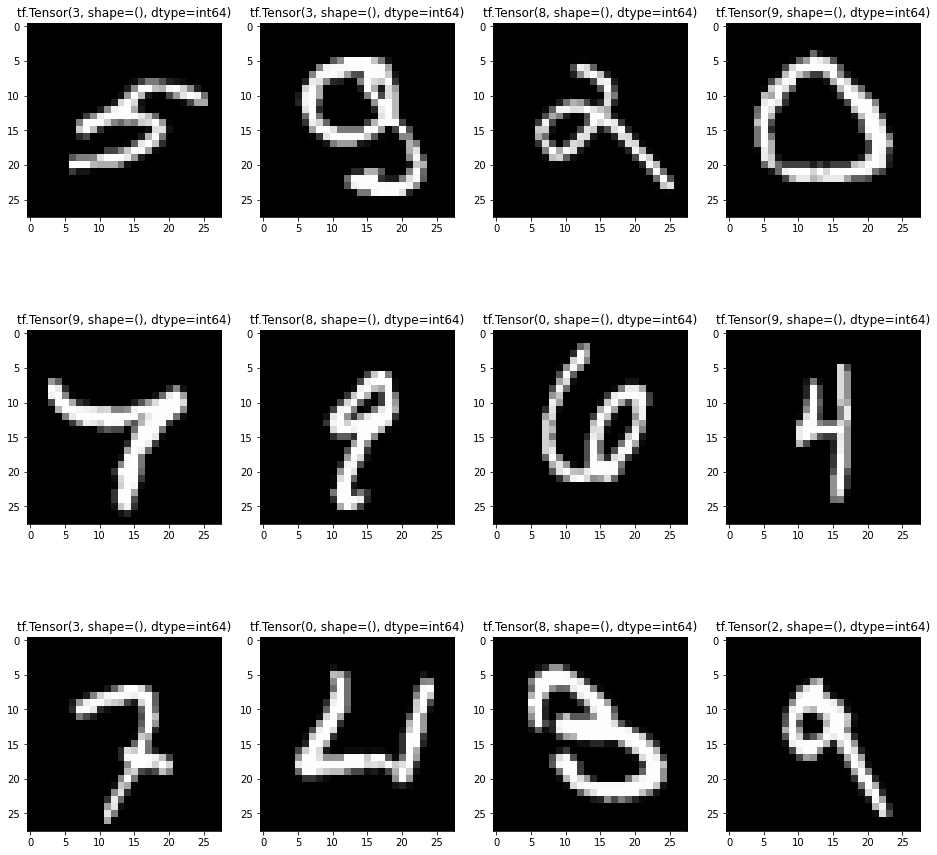

In [ ]:
count = 12  # количество выводимых объектов

fig, axes = plt.subplots(nrows=(count + 3) // 4, ncols=4)
fig.set_size_inches((16, 16))
for i in range(len(correct_predictions)):
    if not correct_predictions[i]:
        axes[(count - 1) // 4, (count - 1) % 4].imshow(X_test[i].reshape(-1, 28), cmap='gray')
        axes[(count - 1) // 4, (count - 1) % 4].set_title(tf.argmax(results[i]).__str__())
        count -= 1
    if count == 0:
        break
plt.show()
